# Financial Time series forecasting

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [1]:
import os
import datetime

from custom_classes import Baseline, DataPrepper, WindowGenerator

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cufflinks as cf

from fastdtw import fastdtw

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-03-04 17:29:27.787186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 17:29:27.871218: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-04 17:29:28.304856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-04 17:29:28.304925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Num GPUs Available:  1


2023-03-04 17:29:28.951143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 17:29:28.971598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 17:29:28.972131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## The Financial dataset

We use Yahoo Finance Brazilian stock data in order to be reproducible.

In [2]:
tickers_list = ["PETR4.SA", "VALE3.SA"]
features_list = ["Open", "High", "Low", "Close", "Volume"]

start_date = "2020-01-01"
end_date = "2023-01-01"

data_prepper = DataPrepper(tickers_list=tickers_list, features_list=features_list, start_date=start_date, end_date=end_date)

data_prepper.prepare()

processed_data = data_prepper.processed_data
original_data = data_prepper.original_data
scalers = data_prepper.scalers

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Note:

We scale the series prior to decomposition.

In [3]:
processed_data["PETR4.SA"].head()

,IMF0_Open,IMF1_Open,IMF2_Open,IMF3_Open,IMF4_Open,Residue_Open,IMF0_High,IMF1_High,IMF2_High,IMF3_High,...,Residue_Close,IMF0_Volume,IMF1_Volume,IMF2_Volume,IMF3_Volume,IMF4_Volume,IMF5_Volume,IMF6_Volume,IMF7_Volume,Residue_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,-0.065669,0.001884,-0.020648,3.197029,1.818399,9.560140,-0.101893,0.091022,-1.194836,4.155289,...,10.722701,7.426474e+06,-1.457255e+07,7.201789e+06,-872246.043522,-4.489082e+07,-9.082837e+06,1.780717e+07,-711152.385791,7.546868e+07
2020-01-03,0.101873,0.000890,-0.026876,3.207821,1.822992,9.560173,0.092805,0.141545,-1.261795,4.224331,...,10.721963,1.688943e+07,6.485591e+06,1.057215e+07,-284716.907984,-4.558364e+07,-9.222308e+06,1.798952e+07,-714223.536742,7.546380e+07
2020-01-06,-0.097721,-0.013698,-0.041752,3.219437,1.826596,9.560276,-0.045293,0.138837,-1.337464,4.289833,...,10.721034,1.802922e+07,1.400991e+07,1.234675e+07,37959.255989,-4.614429e+07,-9.346601e+06,1.816911e+07,-717093.233219,7.545904e+07
2020-01-07,0.083573,0.001301,-0.068724,3.232576,1.829196,9.560451,-0.013035,0.095492,-1.424287,4.351472,...,10.719911,-1.711904e+07,9.354847e+05,1.187713e+07,74778.594005,-4.657153e+07,-9.455290e+06,1.834583e+07,-719758.930515,7.545439e+07
2020-01-08,0.036812,0.010641,-0.109784,3.247487,1.830779,9.560697,0.006700,0.054753,-1.519810,4.408706,...,10.718591,1.469955e+07,-1.259835e+07,9.407466e+06,-127978.390723,-4.686435e+07,-9.547947e+06,1.851956e+07,-722218.083925,7.544986e+07


In [4]:
processed_data["PETR4.SA"].iplot()
processed_data["PETR4.SA"].to_csv("PETR4.csv")

In [5]:
df = pd.read_csv("PETR4.csv")

date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d')

Let's take a glance at the data. Here are the first few rows:

In [6]:
df.head()

,IMF0_Open,IMF1_Open,IMF2_Open,IMF3_Open,IMF4_Open,Residue_Open,IMF0_High,IMF1_High,IMF2_High,IMF3_High,...,Residue_Close,IMF0_Volume,IMF1_Volume,IMF2_Volume,IMF3_Volume,IMF4_Volume,IMF5_Volume,IMF6_Volume,IMF7_Volume,Residue_Volume
0,-0.065669,0.001884,-0.020648,3.197029,1.818399,9.560140,-0.101893,0.091022,-1.194836,4.155289,...,10.722701,7.426474e+06,-1.457255e+07,7.201789e+06,-872246.043522,-4.489082e+07,-9.082837e+06,1.780717e+07,-711152.385791,7.546868e+07
1,0.101873,0.000890,-0.026876,3.207821,1.822992,9.560173,0.092805,0.141545,-1.261795,4.224331,...,10.721963,1.688943e+07,6.485591e+06,1.057215e+07,-284716.907984,-4.558364e+07,-9.222308e+06,1.798952e+07,-714223.536742,7.546380e+07
2,-0.097721,-0.013698,-0.041752,3.219437,1.826596,9.560276,-0.045293,0.138837,-1.337464,4.289833,...,10.721034,1.802922e+07,1.400991e+07,1.234675e+07,37959.255989,-4.614429e+07,-9.346601e+06,1.816911e+07,-717093.233219,7.545904e+07
3,0.083573,0.001301,-0.068724,3.232576,1.829196,9.560451,-0.013035,0.095492,-1.424287,4.351472,...,10.719911,-1.711904e+07,9.354847e+05,1.187713e+07,74778.594005,-4.657153e+07,-9.455290e+06,1.834583e+07,-719758.930515,7.545439e+07
4,0.036812,0.010641,-0.109784,3.247487,1.830779,9.560697,0.006700,0.054753,-1.519810,4.408706,...,10.718591,1.469955e+07,-1.259835e+07,9.407466e+06,-127978.390723,-4.686435e+07,-9.547947e+06,1.851956e+07,-722218.083925,7.544986e+07


### Inspect and cleanup

Next, look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IMF0_Open,745.0,5.099955e-03,2.613705e-01,-1.095441e+00,-1.350983e-01,7.188561e-03,1.366405e-01,9.980115e-01
IMF1_Open,745.0,1.067172e-02,2.898616e-01,-1.187039e+00,-1.205057e-01,4.972175e-03,1.293577e-01,1.802045e+00
IMF2_Open,745.0,-8.287581e-02,7.601446e-01,-2.883428e+00,-3.265412e-01,-2.687581e-02,2.177409e-01,3.576898e+00
IMF3_Open,745.0,1.380767e-01,1.480719e+00,-3.160876e+00,-5.961775e-01,6.076798e-03,1.078908e+00,3.501836e+00
IMF4_Open,745.0,1.422227e-01,1.021073e+00,-1.569466e+00,-6.256392e-01,1.369908e-01,8.801657e-01,2.102897e+00
Residue_Open,745.0,1.539009e+01,5.460448e+00,9.560140e+00,1.075426e+01,1.317504e+01,1.992459e+01,2.541171e+01
IMF0_High,745.0,3.658996e-03,2.469320e-01,-1.210016e+00,-1.211326e-01,1.673010e-02,1.359285e-01,1.139625e+00
IMF1_High,745.0,1.094211e-02,3.308033e-01,-1.882694e+00,-1.300878e-01,3.404768e-03,1.132055e-01,2.085384e+00
IMF2_High,745.0,-5.247062e-02,7.832940e-01,-2.546903e+00,-2.883264e-01,-7.974937e-03,2.195013e-01,2.917991e+00
IMF3_High,745.0,-1.215416e-01,1.444803e+00,-4.067153e+00,-7.991751e-01,-1.523010e-01,4.798624e-01,4.637333e+00


Everything seems ok with the data, no big slippage.

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [8]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

## Checking for periodicity

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the price over time. Search for peak frequencies.


In [9]:
df_fft = pd.DataFrame()
for column in df.columns:

    fft = tf.signal.rfft(df[column])

    df_fft[f"{column}_fft"] = np.abs(fft)

2023-03-04 17:32:24.202272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 17:32:24.204674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 17:32:24.205335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 17:32:24.205704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0

In [10]:
df_fft.iplot()

No clear frquency for periodicity in FFT.

#### Dynamic Time Warping

In [11]:
# target_feature = "Tdew (degC)"
# df_original = df.copy()
# mean = df.mean()
# std = df.std()

# normalized_df_dtw = (df - mean) / std

# target_series = normalized_df_dtw[target_feature]
# distances = []
# for column in normalized_df_dtw:
#     current_comparison_series = normalized_df_dtw[column]
#     distance, _ = fastdtw(target_series, current_comparison_series)
#     distances += [{
#         f"distance": distance,
#         "target_feature" : target_feature,
#         "original_feature" : column
#     }]
# df_distances = pd.DataFrame.from_records(distances).sort_values("distance").reset_index().drop("index", axis="columns")
# df_distances

Cutoff

In [12]:
# significance_ordered_features = df_distances["original_feature"].values
# cutoff_rate = 1
# considered_features = significance_ordered_features[:int(len(significance_ordered_features)*cutoff_rate)]
# df = df_original[considered_features]
# df.head()

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like `-9999` value.

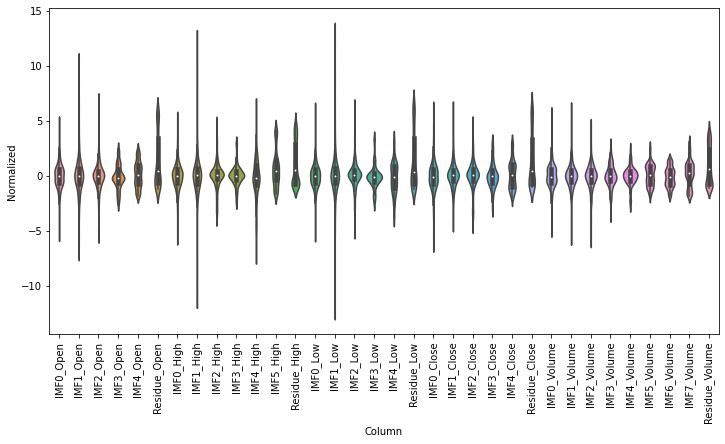

In [15]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [16]:
target_series_name = "IMF0_Close"

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history.

2. A model that makes a prediction one hour into the future, given six hours of history.

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [17]:
w2 = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=[target_series_name])
w2

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['IMF0_Close']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

Splitting

In [18]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 34)
Inputs shape: (3, 7, 34)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

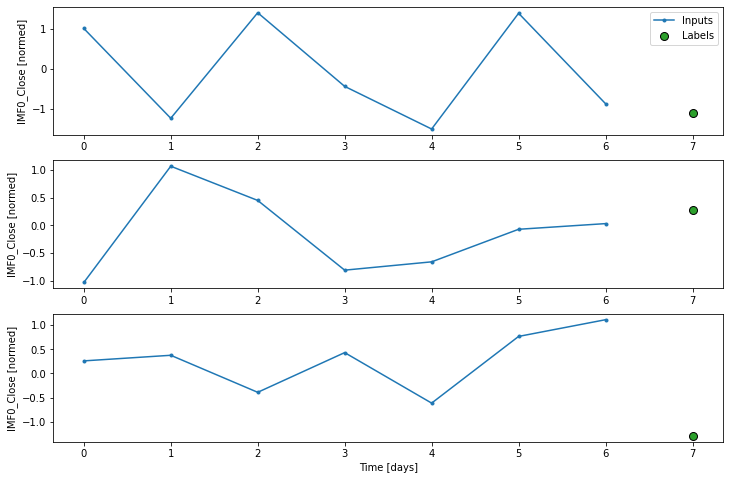

In [21]:
w2.plot()

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [22]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 7, 34), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [23]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 34)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one day) into the future based only on the current conditions.

So, start by building models to predict the `Close` value one day into the future.

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[target_series_name])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['IMF0_Close']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 34)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict a price component one day into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current price as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

Instantiate and evaluate this model:

In [26]:
baseline = Baseline(label_index=column_indices[target_series_name])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 4ms/step - loss: 4.3920 - mean_absolute_error: 1.6810


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [27]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[target_series_name])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['IMF0_Close']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

In [28]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 34)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

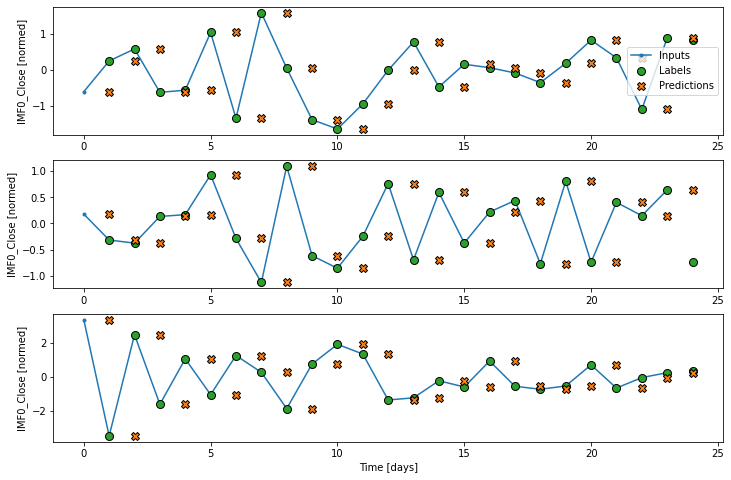

In [29]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [31]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 34)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [32]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [33]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/200


2023-03-04 17:34:57.739028: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efdf0010f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-04 17:34:57.739062: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-03-04 17:34:57.769419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/17 [>.............................] - ETA: 13s - loss: 3.1834 - mean_absolute_error: 1.3936

2023-03-04 17:34:58.022297: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-04 17:34:58.086636: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 1s 16ms/step - loss: 2.5313 - mean_absolute_error: 1.1625 - val_loss: 7.7815 - val_mean_absolute_error: 2.2021
Epoch 2/200
17/17 [==============================] - 0s 9ms/step - loss: 2.2578 - mean_absolute_error: 1.0906 - val_loss: 8.0331 - val_mean_absolute_error: 2.2337
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 8.2948 - mean_absolute_error: 2.2721


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

In [34]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 34)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

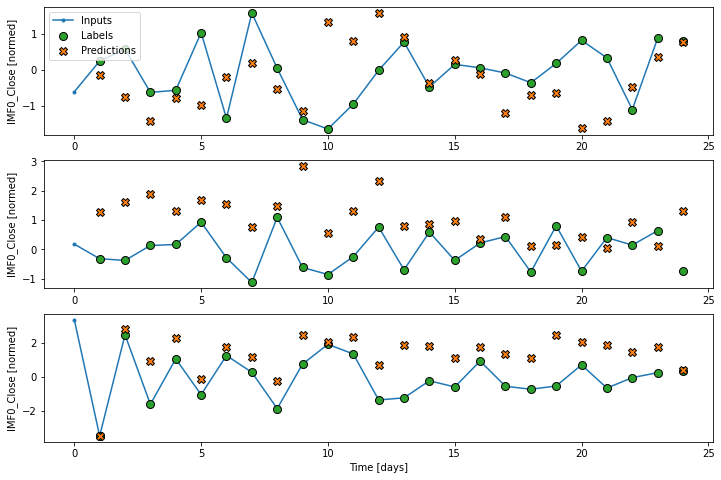

In [35]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

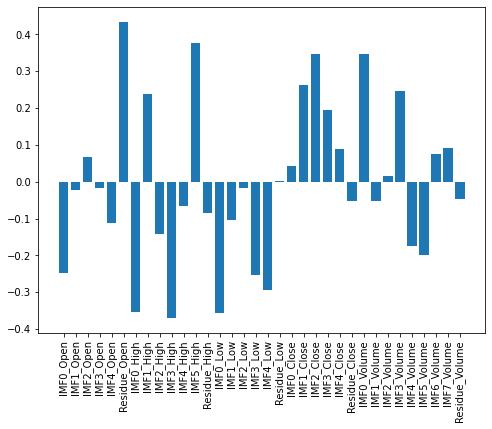

In [36]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `Close`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [37]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/200


2023-03-04 17:35:52.404954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - 1s 18ms/step - loss: 1.0413 - mean_absolute_error: 0.7417 - val_loss: 2.3882 - val_mean_absolute_error: 1.2524
Epoch 2/200
17/17 [==============================] - 0s 13ms/step - loss: 0.8569 - mean_absolute_error: 0.6968 - val_loss: 2.1009 - val_mean_absolute_error: 1.1838
Epoch 3/200
17/17 [==============================] - 0s 12ms/step - loss: 0.7898 - mean_absolute_error: 0.6755 - val_loss: 2.0890 - val_mean_absolute_error: 1.1743
Epoch 4/200
17/17 [==============================] - 0s 11ms/step - loss: 0.7244 - mean_absolute_error: 0.6562 - val_loss: 2.1046 - val_mean_absolute_error: 1.1815
Epoch 5/200
17/17 [==============================] - 0s 12ms/step - loss: 0.6861 - mean_absolute_error: 0.6390 - val_loss: 2.0295 - val_mean_absolute_error: 1.1635
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.6431 - mean_absolute_error: 0.6233 - val_loss: 2.0434 - val_mean_absolute_error: 1.1646
Epoch 7/200
5/5 [===========

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [44]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[target_series_name])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['IMF0_Close']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

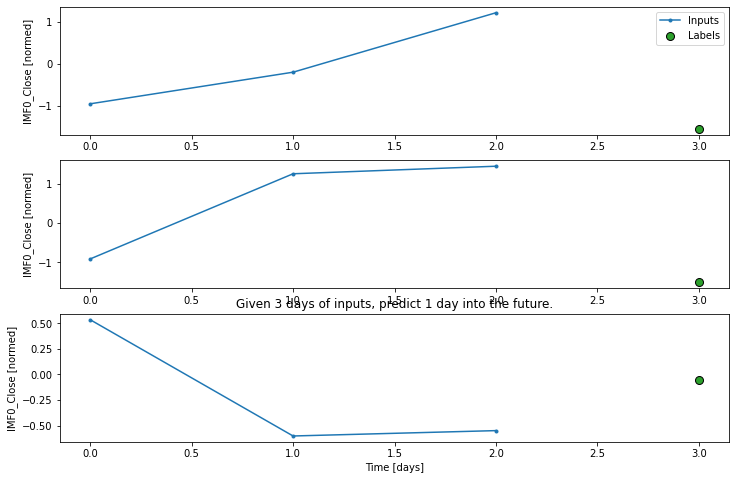

In [45]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [46]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [47]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 34)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 4ms/step - loss: 2.1879 - mean_absolute_error: 1.1688


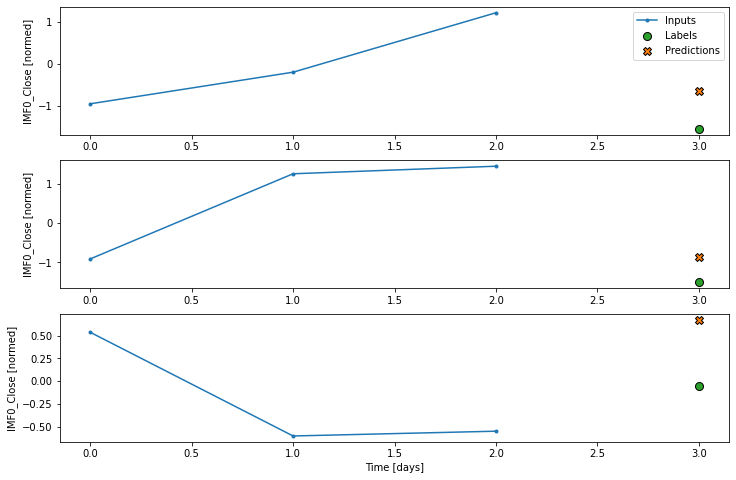

In [51]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [52]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 34)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 102, but received input with shape (32, 816)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 34), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [53]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [54]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 34)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 5ms/step - loss: 2.0342 - mean_absolute_error: 1.1945


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 34)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [60]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[target_series_name])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['IMF0_Close']

In [61]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 34)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

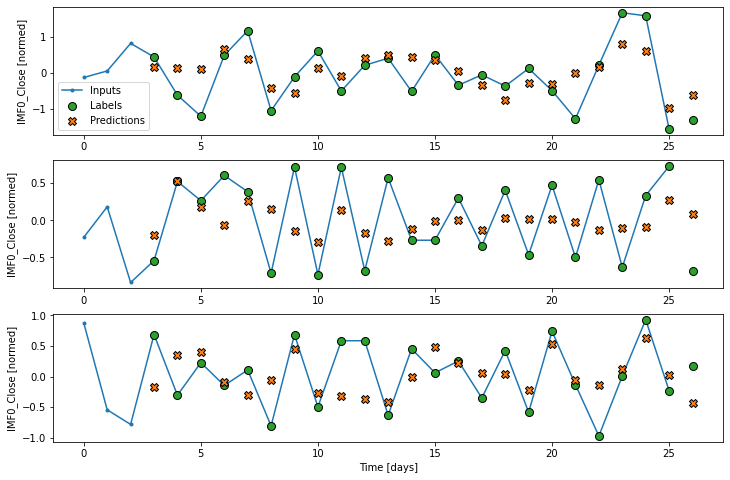

In [62]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [63]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [64]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 34)
Output shape: (32, 24, 1)


In [65]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 5ms/step - loss: 1.8000 - mean_absolute_error: 1.1084


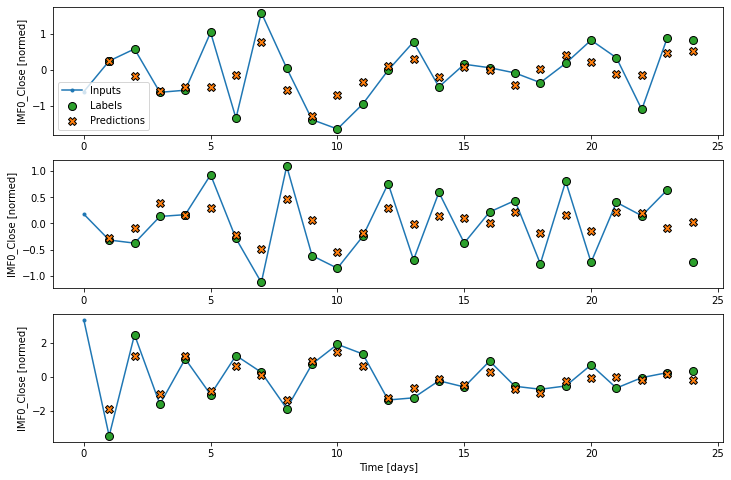

In [66]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

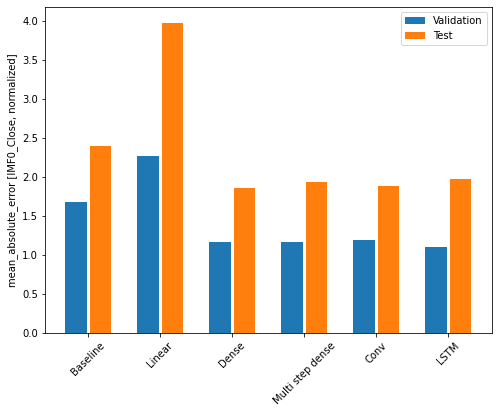

In [69]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'mean_absolute_error [{target_series_name}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [70]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 2.3989
Linear      : 3.9816
Dense       : 1.8613
Multi step dense: 1.9333
Conv        : 1.8910
LSTM        : 1.9759


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [72]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 34)
Labels shape (batch, time, features): (32, 24, 34)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [73]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [74]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 5ms/step - loss: 0.6875 - mean_absolute_error: 0.3900


#### Dense

In [75]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [76]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 6ms/step - loss: 1.6570 - mean_absolute_error: 0.9828


#### RNN


In [79]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

4/4 [==============================] - 0s 8ms/step - loss: 2.3455 - mean_absolute_error: 1.1541

CPU times: user 10.2 s, sys: 3.63 s, total: 13.8 s
Wall time: 8.12 s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [80]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [81]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

4/4 [==============================] - 0s 5ms/step - loss: 0.4406 - mean_absolute_error: 0.3291

CPU times: user 10.3 s, sys: 3.85 s, total: 14.1 s
Wall time: 7.97 s


#### Performance

Here is the overall performance for these multi-output models.

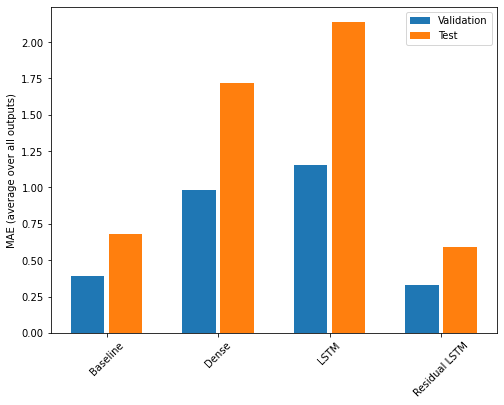

In [82]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [83]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.6819
Dense          : 1.7163
LSTM           : 2.1360
Residual LSTM  : 0.5930


The above performances are averaged across all model outputs.